In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels import api as sm
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing

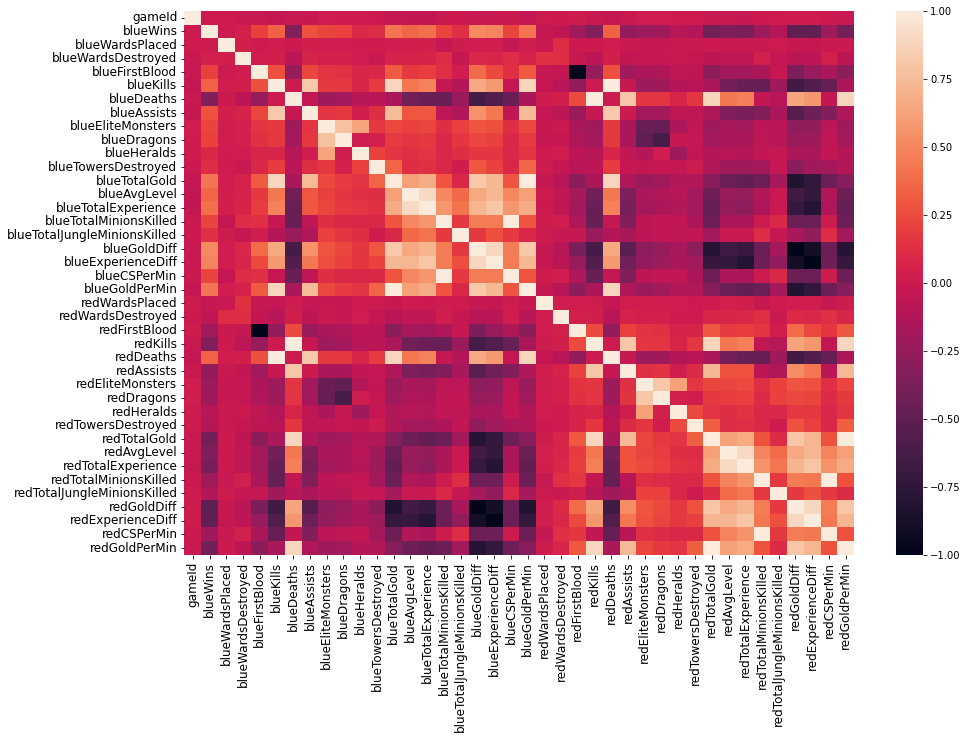

In [2]:
data = pd.read_csv('high_diamond_ranked_10min.csv')
x = data.drop(['gameId', 'blueWins'], axis=1) # skip gameId and blueWins
y = data['blueWins'] # blueWins

corr_coeffs = data.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_coeffs, vmin=-1.0, vmax=1.0)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12)
fig.set_facecolor('white')

^ remove redDeaths + blueDeaths => they're highly correlated with red/blueKills (obviously)

CSPerMin, and GoldPerMin could be removed as they are related to the TotalMinions etc, and TotalGold. AND we're predicting at 10 min, not per minute. (probably?)

### Clean + Split

In [3]:
x = x.drop(['redDeaths', 'blueDeaths', 'redCSPerMin', 'blueCSPerMin', 'redGoldPerMin', 'blueGoldPerMin'], axis=1)

In [4]:
cutoff_train = round(x.shape[0] * 0.5)
cutoff_val = round(x.shape[0] * 0.75)
print(cutoff_train)
print(cutoff_val)

train_X = x[:cutoff_train].to_numpy()
train_y = y[:cutoff_train].to_numpy()

val_X = x[cutoff_train:cutoff_val].to_numpy()
val_y = y[cutoff_train:cutoff_val].to_numpy()

test_X = x[cutoff_val:].to_numpy() # the rest
test_y = y[cutoff_val:].to_numpy()

print(train_X.shape)
print(val_X.shape)
print(test_X.shape)

print(test_y.shape)

4940
7409
(4940, 32)
(2469, 32)
(2470, 32)
(2470,)


### Standardise

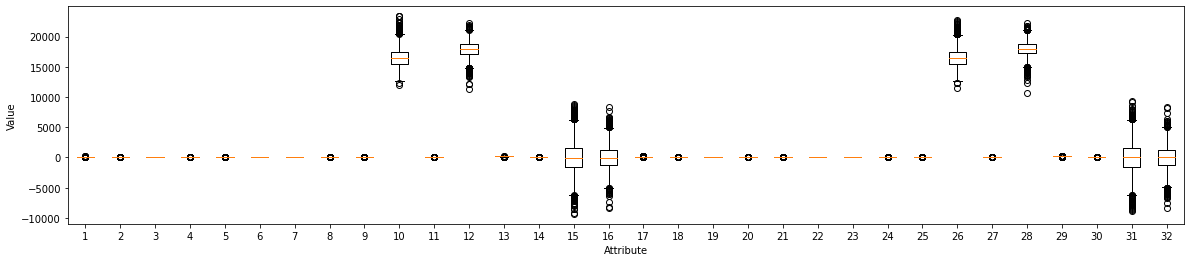

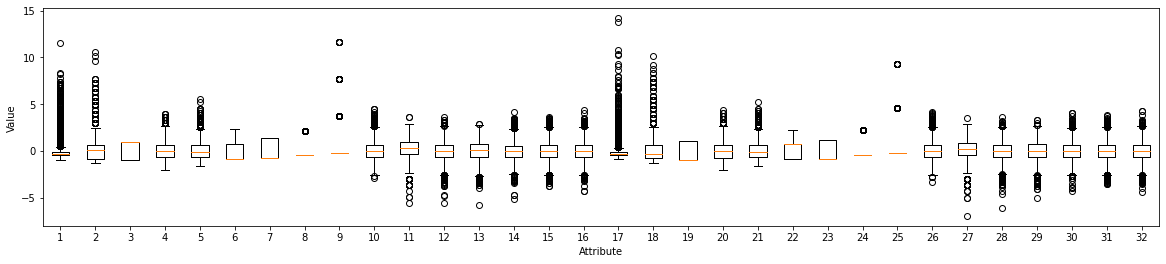

In [5]:
fig, ax = plt.subplots(figsize=(20,4))
plt.boxplot(train_X)
plt.xlabel("Attribute")
plt.ylabel("Value")
fig.set_facecolor('white')

mu = np.mean(train_X, axis=0)
sigma = np.std(train_X, axis=0)
std = (train_X - mu) / sigma
fig, ax = plt.subplots(figsize=(20,4))
plt.boxplot(std)
plt.xlabel("Attribute")
plt.ylabel("Value")
fig.set_facecolor('white')

^ profound effect, so standardise

In [6]:
train_X = (train_X - mu) / sigma
val_X = (val_X - mu) / sigma
test_X = (test_X - mu) / sigma

# Helper functions

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report

# helper function adapted from lecture examples

# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - get precision, recall, f1 for test data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, x_train, y_train, x_test, y_test):
    fig = plt.figure(figsize=[10, 5])
    fig.set_facecolor('white')

    ax = fig.add_subplot(1, 2, 1)
    pred = model.predict(x_train);
    cm = confusion_matrix(y_train, pred)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)
    ax.set_title('Training Set Performance: %1.3f' % (sum(pred == y_train)/len(y_train)));
    
    ax = fig.add_subplot(1, 2, 2)
    
    pred = model.predict(x_test);

    cm = confusion_matrix(y_test, pred)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)    
    ax.set_title('Testing Set Performance: %1.3f' % (sum(pred == y_test)/len(y_test)));

    print(classification_report(y_test, pred))

## ! Evaluation of binary classifiers (might need to do this)

https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers

"Instead, measures such as the phi coefficient, Matthews correlation coefficient, informedness or Cohen's kappa may be preferable to assess the performance of a binary classifier."[17][18]

# Ensemble Classifier

## Random Forest 🌲🌲🌲

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1237
           1       0.73      0.74      0.73      1233

    accuracy                           0.73      2470
   macro avg       0.73      0.73      0.73      2470
weighted avg       0.73      0.73      0.73      2470



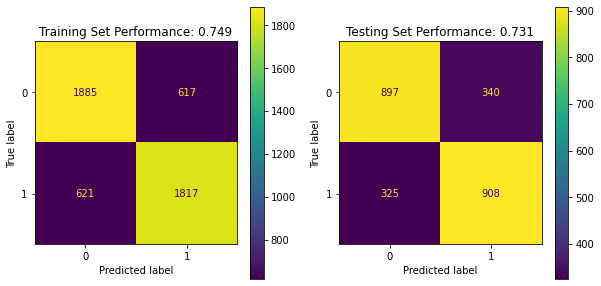

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# create and train model
rf = RandomForestClassifier(n_estimators=100, max_depth= 5, random_state=0)
rf.fit(train_X, train_y)

eval_model(rf, train_X, train_y, test_X, test_y)

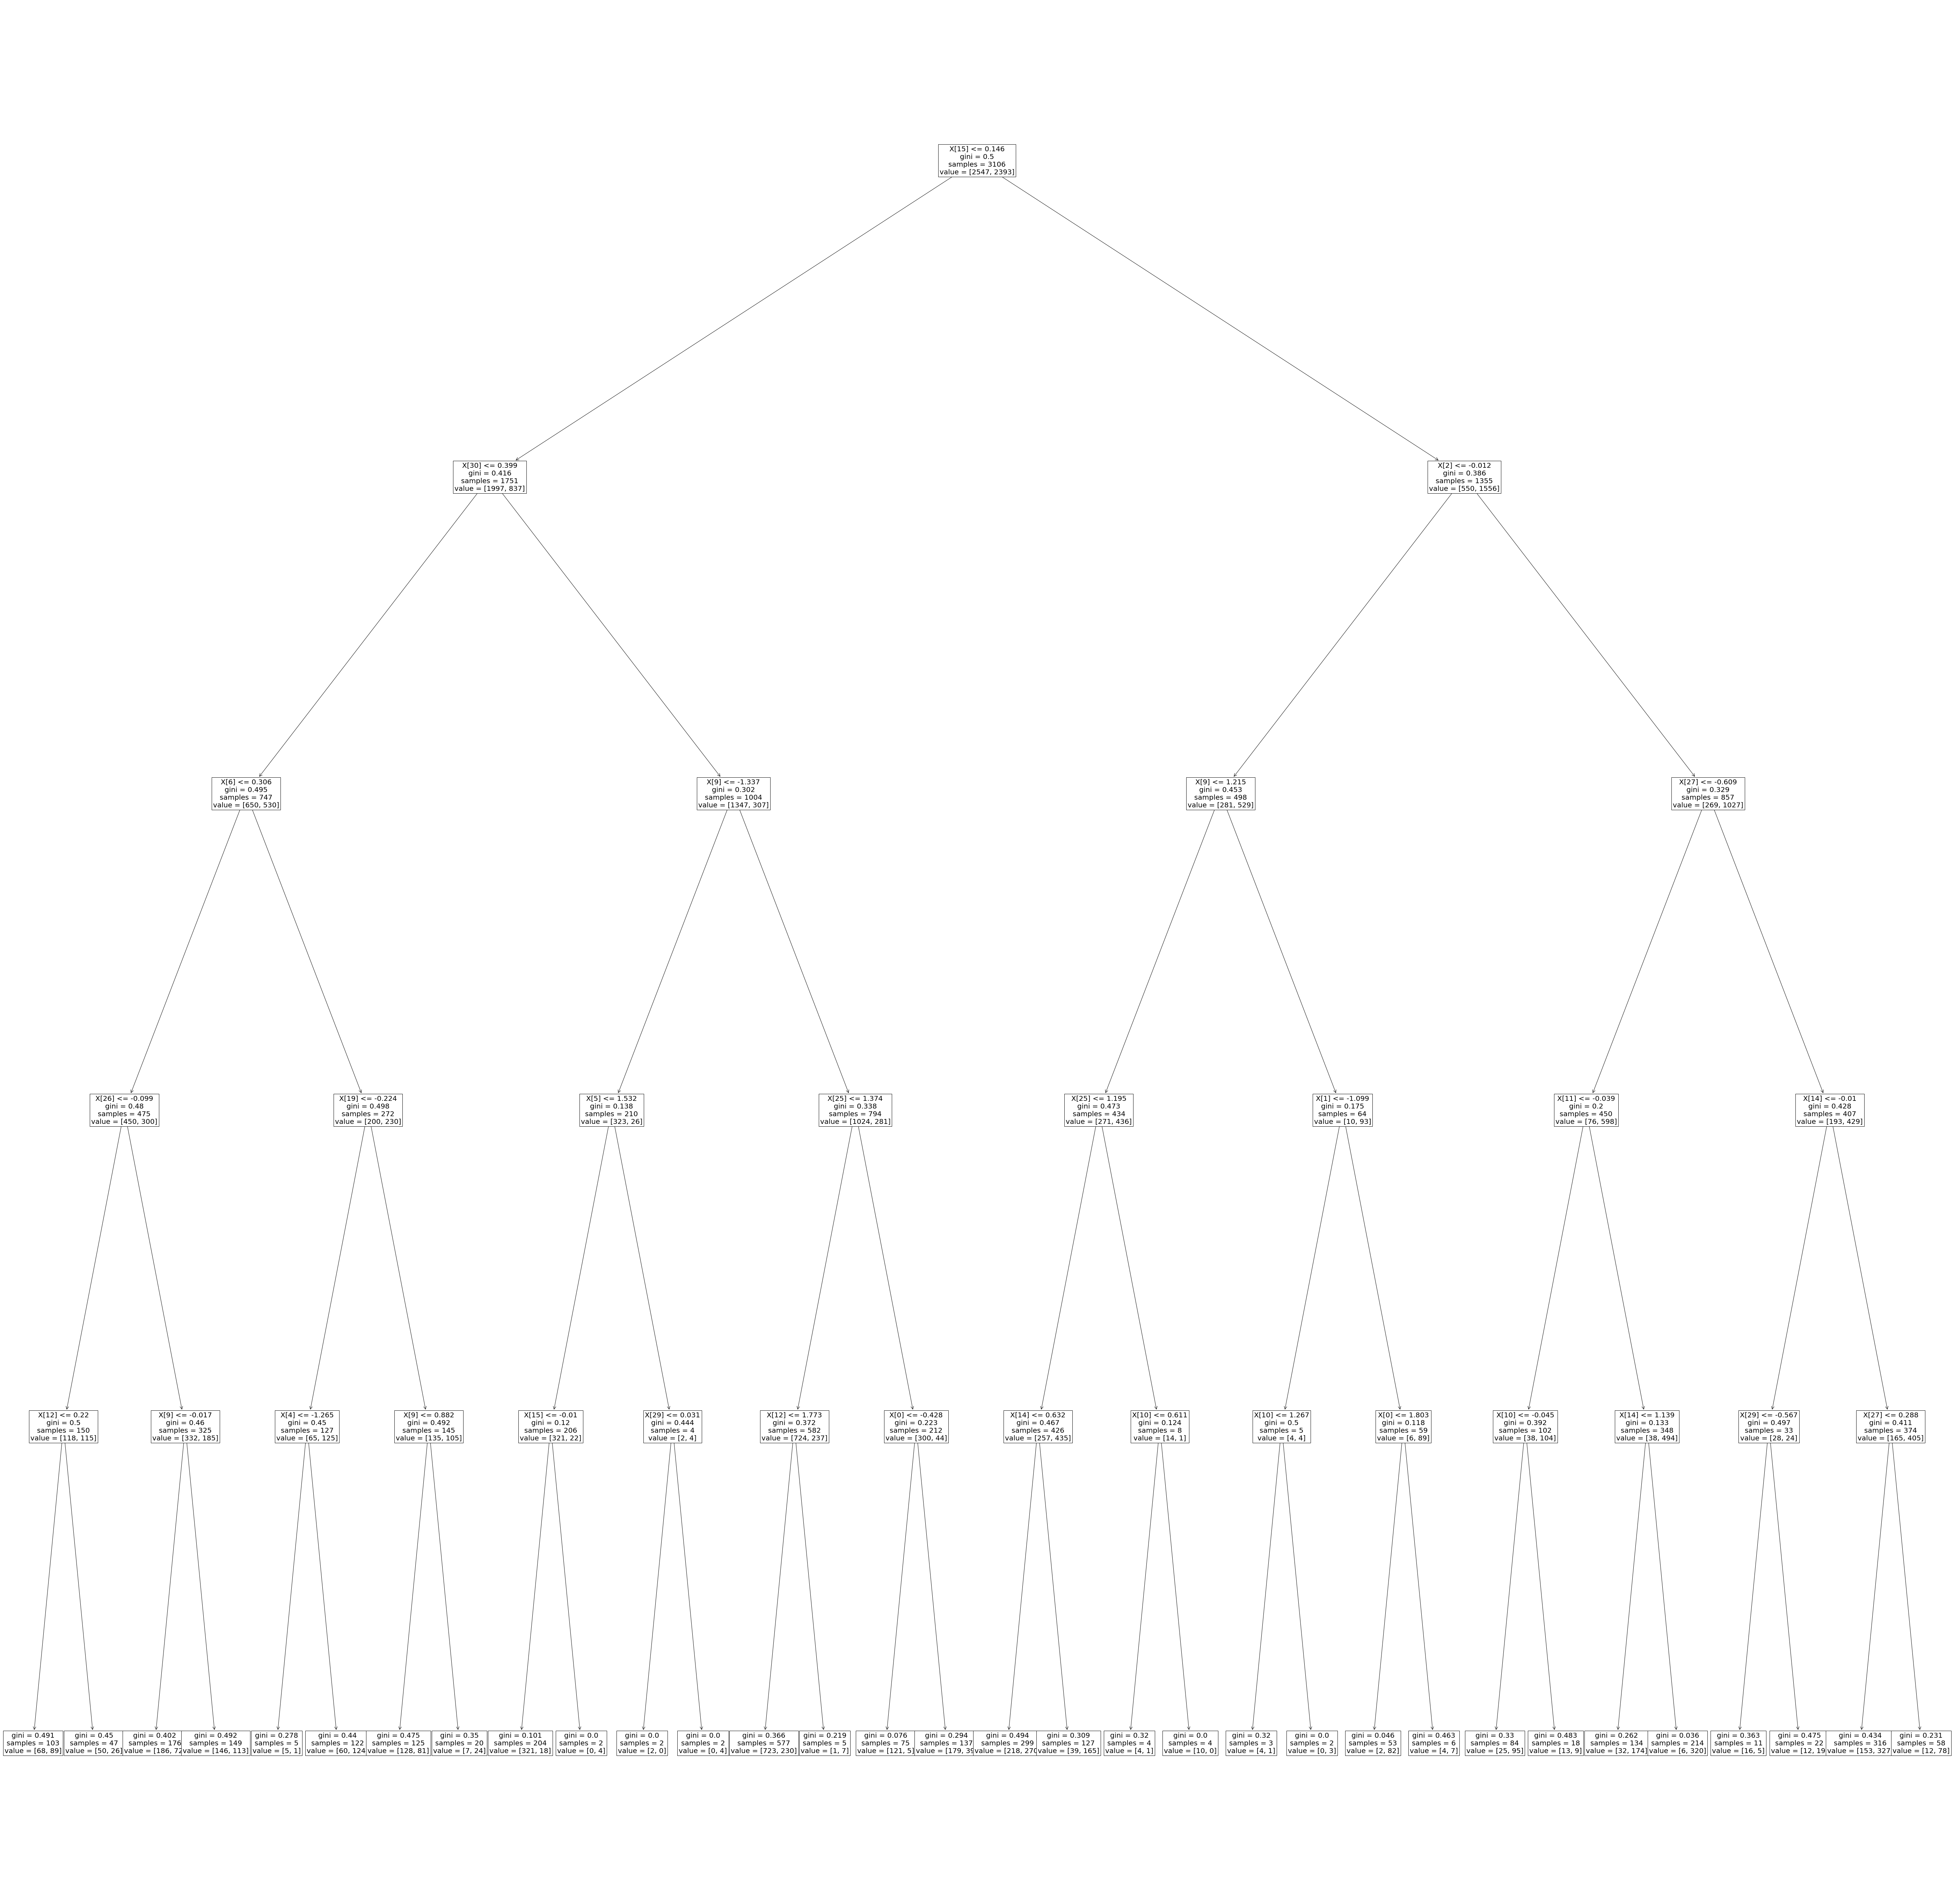

In [9]:
# plot tree
fig = plt.figure(figsize=(100, 100))
_ = tree.plot_tree(rf.estimators_[0], fontsize=20)


# SVM classfier

              precision    recall  f1-score   support

           0       0.71      0.72      0.72      1237
           1       0.72      0.71      0.71      1233

    accuracy                           0.72      2470
   macro avg       0.72      0.72      0.72      2470
weighted avg       0.72      0.72      0.72      2470



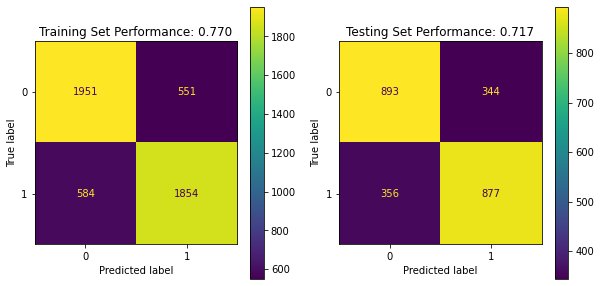

In [15]:
from sklearn.svm import SVC

# test default svc
svm = SVC()
svm.fit(train_X, train_y)
eval_model(svm, train_X, train_y, test_X, test_y) 

test with param grid using C and other parameters (grid search)

In [11]:
from sklearn.model_selection import GridSearchCV

###
# BRUH this takes me 24 mins to run on a 5600x, maybe cuz of data otherwise may need to narrow down parameters
###

param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [2, 3, 4, 5, 6], 'kernel': ['poly']},
 ]
svm = SVC()
grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(train_X, train_y)
grid_search.cv_results_

{'mean_fit_time': array([  0.26970572,   0.51987352,   2.38497291,  18.3587647 ,
        175.28513041,   0.39551167,   0.31198282,   0.34507461,
          0.44020362,   0.43773804,   0.30464754,   0.30156794,
          0.34537621,   0.63051357,   0.39115615,   0.31333623,
          0.31522808,   0.64879045,   0.93913126,   0.4220716 ,
          0.3242959 ,   0.65310102,   4.29899602,   0.95178971,
          0.38635139,   0.32569671,   0.26944523,   0.32689943,
          0.3053977 ,   0.38625655,   0.36853518,   0.31373391,
          0.37853751,   0.36800513,   0.40829411,   0.72446136,
          0.67823944,   0.52247591,   0.49450483,   0.45434966,
          4.12067237,   2.76577573,   1.18132677,   0.99857273,
          0.81517582,  46.29030752,  12.78626757,   1.38599629,
          0.90061955,   0.79814558]),
 'std_fit_time': array([5.04122819e-03, 1.21537457e-02, 4.53484073e-02, 1.06388408e+00,
        1.03039436e+01, 8.20382737e-03, 5.19218199e-03, 3.37054649e-03,
        3.8165526

{'C': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1237
           1       0.73      0.73      0.73      1233

    accuracy                           0.73      2470
   macro avg       0.73      0.73      0.73      2470
weighted avg       0.73      0.73      0.73      2470



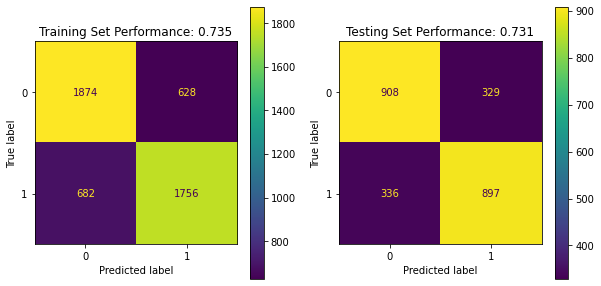

In [14]:
best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
svm = SVC().set_params(**params)
svm.fit(train_X, train_y)
eval_model(svm, train_X, train_y, test_X, test_y)

# DNN (dense layers)

# 3rd TBD

https://www.kaggle.com/code/carlmcbrideellis/tabnet-simple-binary-classification-example/notebook

https://github.com/dreamquark-ai/tabnet

### Helper

In [17]:
def model_history(history):
    fig = plt.figure(figsize=[21, 6])
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='loss')
    # plt.plot(history.history['accuracy'], label='accuracy')
    # plt.plot(history.history['val_loss'], label='val_loss')
    # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    ax.legend()
    ax.set_title('Training Performance')

### Model

pip install pytorch-tabnet

https://dreamquark-ai.github.io/tabnet/

In [18]:
from pytorch_tabnet.tab_model import TabNetClassifier

classifier = TabNetClassifier(verbose=0,seed=42)
classifier.fit(X_train=train_X, y_train=train_y,
               patience=10, max_epochs=50,
               eval_metric=['accuracy'])
model_history(classifier.history)

ModuleNotFoundError: No module named 'pytorch_tabnet'

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1237
           1       0.71      0.71      0.71      1233

    accuracy                           0.71      2470
   macro avg       0.71      0.71      0.71      2470
weighted avg       0.71      0.71      0.71      2470



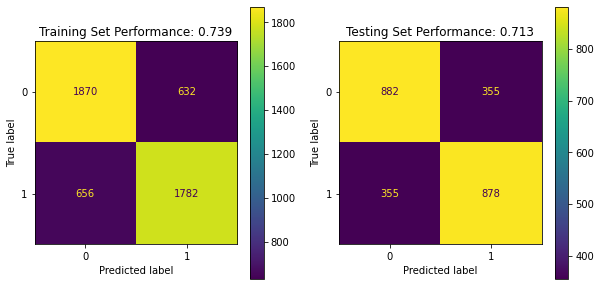

In [ ]:
eval_model(classifier, train_X, train_y, test_X, test_y)